Ce notebook contient toutes les étapes qui nous permettent de traiter les données et d'entrainer notre IA.

## Importations des packages 


In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

import gc

## Recuperation des images au bon format 
Pour cela nous avons défini une fonction pour: 
- le chargement des images sous forme de tableau 
- la normalisation , c'est a dire transformé chaque image en un tableau unidimzntionel de valeur comprises entre 0 et 1 
- la dénormalisation pour les retrnasformé en tableau 3D 
- leur  affichage.

In [4]:
def load_images_from_folder(folder_path, target_size=None):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            image = Image.open(img_path)
            if target_size:
                image = image.resize(target_size)  # Redimensionner l'image si nécessaire
            image_array = np.array(image)  # Convertir l'image en tableau NumPy
            images.append(image_array)
            filenames.append(filename)
    return np.array(images), filenames

def normalize(images):
    s=images.shape
    images = images.astype("float32")/255
    images = images.reshape(s[0],s[1]*s[2]*s[3])
    return images

def normalize_conv(images):
    images = images.astype("float32")/255
    return images

def denormalize(img):
    img = img.reshape(400,400,3)
    return img

def plotimage(img):
    img = denormalize(img)
    plt.imshow(img)
    plt.axis('off')  # Masquer les axes
    plt.show()



Affichage d'une image 

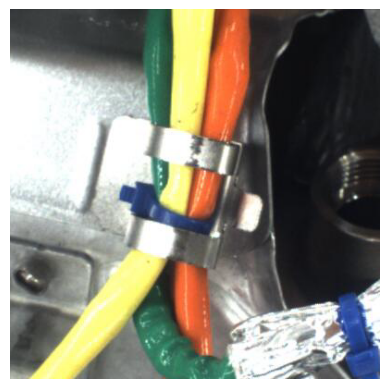

In [5]:
folder_path = '/home/jgayraud/Documents/MIC3/BE/engine_wiring/train/good'
target_size = (400, 400)  
images, filenames = load_images_from_folder(folder_path, target_size)

images_conv = normalize_conv(images)
images = normalize(images)
plotimage(images[3,:])


## Definition du modèle ( modele des couches linéaire )

Nous avons dans un premirer temps implémenter un endoceur et un decodeur avec uniquement des couches linéaire. 
Ce modèle n'eétait pas tres efficace car les couches liéaire ne sont pas tres adaptées pour le traitement d'image. En effet,
- elle nécessite la transformation ds images qui sont des tableaux 3D en des tableaux 1D ce qui entraine une perte importante d'information au niveau des pixels 
- elle ne reconnaît pas bien les formes et ne permet pas de capturer les détails effectivement 
- elle utilisent trop paramaetre aussi
- 

In [7]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(400*400*3, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 20)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(20, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500,400*400*3),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Définition du modèle ( fonction pour encodeur et décodeur)

### Encodeur 
Après avoir essayer l'encodeur simple avec l'encodeur simple avec des couches liéaires nous sommes passé a un encodeur avec 4 couches de convolutions et une couche liéaire en utlisant comme fonctions d'activation ReLU.

En effet,les couches de convolutions permettent de glisser un filtre sur l’image et détecte des motif. 
Elles permettent, tout en réduisant la taille des données d'entrées, d'avoir une meilleure analyse des images en extrayant automatiquement les caractéristiques importantes comme :les bords, les textures,les formes complexes, les relations spatiales entre les pixels

Ensuite on transforme notre tableau image en un vecteur pour l'espace latent grace la focntion flatten() et une couche linéaire.

### Decodeur 
Apres avoir retrnasformé le vectuer de l'espace latent en tableau, nous somme également passé a un décoceur utilisant des couches de convolution et des fonction d'activation ReLU.

In [8]:
class AE_CNN(torch.nn.Module):
    def __init__(self):
        super(AE_CNN, self).__init__()
       
        # --- ENCODEUR CNN ---
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 400x400 → 200x200
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 200x200 → 100x100
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 100x100 → 50x50
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 50x50 → 25x25
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(256 * 25 * 25, 20)  # Vecteur latent de taille 20
        )
       
        # --- DÉCODEUR CNN ---
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(20, 256 * 25 * 25),  # Reconversion du vecteur latent
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (256, 25, 25)),  # Reformater en "image" 2D
           
            torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 25x25 → 50x50
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 50x50 → 100x100
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 100x100 → 200x200
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 200x200 → 400x400
            torch.nn.Sigmoid()  # Normalisation entre 0 et 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.device("cpu") 
print(device)

cuda


Definition du loader ( la database qui va servir à s'entrainer en prenant en compte le bash (nombre d'itérations avant update)) et de certains hyperparamètres

In [10]:
#images_for_conv = images.reshape(images[0],400,400,3 )

In [57]:
# les to(device) deplace les objets sur le gpu pour faire le training
torch.cuda.empty_cache()
if 'model' in locals():
    del model
if 'optimizer' in locals():
    del optimizer
if 'images_tensor' in locals():
    del images_tensor
if 'dataset' in locals():
    del dataset
if 'loader' in locals():
    del loader


model = AE_CNN().to(device)
BashSize = 32


loss_function = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-5)


images_tensor = torch.tensor(images, dtype=torch.float32).to(device)

images_tensor_conv = torch.tensor(images_conv, dtype=torch.float32).permute(0,3,1,2).to(device)



#dataset = TensorDataset(images_tensor)

loader = torch.utils.data.DataLoader(dataset = images_tensor_conv,
                                     batch_size = BashSize,
                                     shuffle = True)

## Entrainement du modèle 
Nous avons entrainement notre modèle sur 20, 30, 50 et 100 epochs obtenant des resultats beaucoup plus net a chaque fois qu'on augmente.

Nous avons rencontrer un probleme de gestion de memoire donc avons fait attention a supprimer ce qui ne  nous sert plus pour libérer la mémoire a chaque itération (inputs, targets, outputs)

In [58]:
num_epochs = 100
losses = []
optimizer.zero_grad()
for epoch in range(num_epochs):
    for batch in loader:
        # Séparer les données d'entrée et les cibles (ici, les mêmes images)
        inputs = batch.to(device)
        targets = inputs
        
        # Passer les données dans le modèle

        outputs = model(inputs)
        # Calculer la perte
        loss = loss_function(outputs, targets)
        
        # Rétropropagation et mise à jour des poids

        loss.backward()
        optimizer.step()    
        # Remettre les gradients à zéro
        optimizer.zero_grad()
        

        losses.append(loss.item())
        # supprimer ce qui ne nous sert plus pour libérer la mémoire (probleme de taille)
        del inputs, targets, outputs
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Entraînement terminé.")



Epoch [1/100], Loss: 0.6931
Epoch [2/100], Loss: 0.6923
Epoch [3/100], Loss: 0.6887
Epoch [4/100], Loss: 0.6089
Epoch [5/100], Loss: 0.5669
Epoch [6/100], Loss: 0.5435
Epoch [7/100], Loss: 0.5477
Epoch [8/100], Loss: 0.5488
Epoch [9/100], Loss: 0.5467
Epoch [10/100], Loss: 0.5466
Epoch [11/100], Loss: 0.5421
Epoch [12/100], Loss: 0.5419
Epoch [13/100], Loss: 0.5406
Epoch [14/100], Loss: 0.5347
Epoch [15/100], Loss: 0.5383
Epoch [16/100], Loss: 0.5307
Epoch [17/100], Loss: 0.5182
Epoch [18/100], Loss: 0.5217
Epoch [19/100], Loss: 0.5197
Epoch [20/100], Loss: 0.5177
Epoch [21/100], Loss: 0.5090
Epoch [22/100], Loss: 0.5073
Epoch [23/100], Loss: 0.4977
Epoch [24/100], Loss: 0.5058
Epoch [25/100], Loss: 0.5000
Epoch [26/100], Loss: 0.5005
Epoch [27/100], Loss: 0.4926
Epoch [28/100], Loss: 0.4891
Epoch [29/100], Loss: 0.4927
Epoch [30/100], Loss: 0.4922
Epoch [31/100], Loss: 0.4941
Epoch [32/100], Loss: 0.4924
Epoch [33/100], Loss: 0.4876
Epoch [34/100], Loss: 0.4823
Epoch [35/100], Loss: 0

Enregistrement des poids pour les utiliser plus tard sans relancer le training

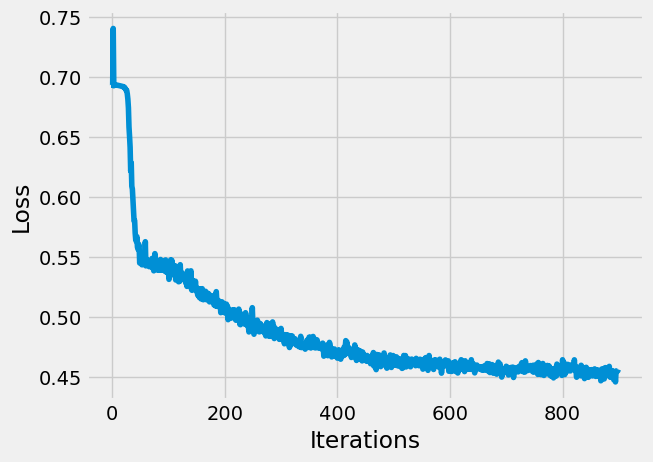

In [59]:
losses_np = [loss for loss in losses]

# Définir le style du graphique
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Tracer les 100 dernières valeurs de perte
plt.plot(losses_np[:])

# Afficher le graphique
plt.show()

Nous avons essayé dans un premier temps 10 époques mais nous remarquons une augmentation sygnificative du loss au bout de 5 époques. Nous devons modifier les hyperparamètres pour avoir un meilleur modèle.

Passage d'une image dans le modèle, pour vérifier la robustesse du modèle : Attention ceci est pour le modele linéaire

In [27]:
# Convertir l'image en tenseur
number = 3

image_tensor = torch.tensor(images[number, :], dtype=torch.float32).view(1, -1)

# Passer l'image à travers le modèle pour obtenir la reconstruction
model.eval()  # Passer le modèle en mode évaluation
with torch.no_grad():
    reconstructed_image = model(image_tensor)

# Remettre en forme et afficher l'image originale et la reconstruction
original_image = images[number, :].reshape(400, 400, 3)
reconstructed_image = reconstructed_image.view(400, 400, 3).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title('Image Reconstruite')
plt.imshow(reconstructed_image)

plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 480000]

## Visualisation
Passage d'une image des données d'entrainement dans le modèle, pour vérifier la robustesse du modèle

torch.Size([1, 3, 400, 400])
torch.Size([1, 3, 400, 400])
(400, 400, 3)


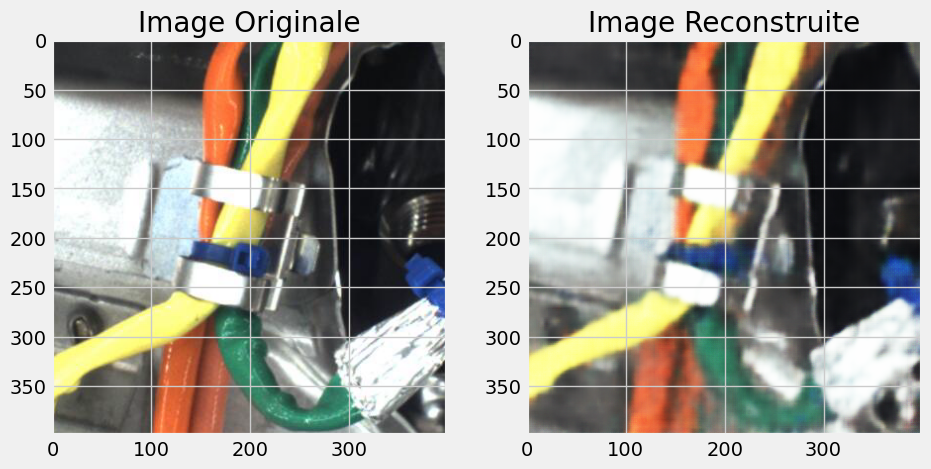

tensor([0.1961, 0.2078, 0.2196,  ..., 0.3961, 0.4980, 0.6745], device='cuda:0')
[[0.32917014 0.34660542 0.34510222]
 [0.17317362 0.19644548 0.26220715]
 [0.18235245 0.18575427 0.20460862]
 ...
 [0.3604966  0.3878651  0.3571752 ]
 [0.36421156 0.37168968 0.37599668]
 [0.37209412 0.3817297  0.3765797 ]]


In [61]:
# Convertir l'image en tenseur
number = 20

image_tensor = torch.tensor(images_conv[number, :,:,:], dtype=torch.float32).cuda().permute(2,0,1).reshape(1,3,400,400)
print(image_tensor.shape)
# Passer l'image à travers le modèle pour obtenir la reconstruction
model.eval()  # Passer le modèle en mode évaluation
with torch.no_grad():
    reconstructed_image = model(image_tensor)

# Remettre en forme et afficher l'image originale et la reconstruction
original_image = images_conv[number, :,:,:]
print(reconstructed_image.shape)
reconstructed_image = reconstructed_image.cpu().squeeze(0).permute(1,2,0).numpy()

print(reconstructed_image.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title('Image Reconstruite')
plt.imshow(reconstructed_image)

plt.show()

print(images_tensor[3])
print(reconstructed_image[3])

Pour l'instant, nous avons une image de sortie similaire peu importe l'image de départ. On suppose que le modèle est mal entrainé (Trop d'époques ou autres), ou une erreur dans lecode

# Enregistrement des poids